# Image Multi-Class Classification Modeling on Art Genres
### By Isaiah Westphalen


## Problem Statement
-------
>Different genres of art incorporate the use of different mediums, subject matter, and color palettes to produce unique and meaningful peices. Using multi-class image classification that optimizes for accuracy we can develop a model that will be able to determine which genre an art piece belongs to. From this we can understand what features and practices define each genre and gain a better understanding of the nuances of artistic expression. In this case, we'll be utilizing a convolutional neural network to model and get our results.




## The Data/EDA
----
>Here we'll be using the Painter by Numbers image data set from [kaggle](https://www.kaggle.com/c/painter-by-numbers/data?select=train_3.zip). Along with ~ 80,000 images, we'll also be using the train_info.csv they provide to determine which genre each image file belongs. We can read that in using pandas to begin getting a look at the data:

In [19]:
# importing libraries
import numpy as np
import pandas as pd
from plotly import express as px

#reading in data
info = pd.read_csv("train_info.csv")

info.head()

,filename,artist,title,style,genre,date
0,102257.jpg,5b39c876740bfc1cfaf544721c43cac3,Uriel,Color Field Painting,abstract,1955.0
1,75232.jpg,5b39c876740bfc1cfaf544721c43cac3,Vir Heroicus Sublimis,Color Field Painting,abstract,1950.0
2,29855.jpg,96e5bc98488ed589b9bf17ad9fd09371,Night March of a Hundred Demons (left half),Yamato-e,mythological painting,NaN
3,62252.jpg,5b39c876740bfc1cfaf544721c43cac3,"Who’s Afraid of Red, Yellow and Blue II",Color Field Painting,abstract,NaN
4,63861.jpg,5b39c876740bfc1cfaf544721c43cac3,Black Fire I,Color Field Painting,abstract,1963.0


For our purposes, we are only looking at genres, so all we need from this dataframe is the filename and genre. We can then make a new dataframe assigning each image to a train or a test group (we'll use a 0.8 trainsize and 0.2 test size):

In [ ]:
#getting filenames and genres
df = info[['filename', 'genre']].rename({'filename':'filename', 'genre':'cat'}, axis = 1)

#we also need to make sure our filenames are correct
df.filename = df.filename.map(lambda x: 'train/' + x)

#creating dataframe with train/test labels
fulldf = pd.DataFrame()
for i in df['cat'].unique():
  train_size=int(round(0.8*len(df[df['cat']==i]),0))
  test_size = int(round(0.2*len(df[df['cat']==i]),0))
  if sum([train_size,test_size])<len(df[df['cat']==i]):
    while sum([train_size,test_size])<len(df[df['cat']==i]):
      val_size+=1
  temp = df[df['cat']==i]
  temp['type'] = np.random.choice(np.repeat(['train', 'test'], (train_size,test_size)), len(temp), replace=False)
  fulldf = pd.concat([fulldf,temp])


Now we can examine out data:


In [55]:
print(fulldf.shape)

fulldf.head()

(78540, 3)


,filename,cat,type
0,train/102257.jpg,abstract,train
1,train/75232.jpg,abstract,train
3,train/62252.jpg,abstract,train
4,train/63861.jpg,abstract,train
14,train/59145.jpg,abstract,train


Now let's plot the number of files per genre:

In [51]:
count = pd.DataFrame(fulldf.cat.value_counts()).reset_index().rename({'index': 'genre'}, axis = 1)

px.bar( count, x = count['genre'], y = count['cat'], title = 'Genre Counts', labels = {'cat': 'Count', 'genre': 'Genres'})

As we can see, there seems to be a class imbalance that we need to deal with. In this case, we'll use bootstrappping to increase the number of entries under represented genres have, and we'll under sample the entries for genres with a lot of images available. In order to account for computing time we'll set the cap for number of entries at 600:

In [25]:
#importing more libraries 
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os
from PIL import Image
from skimage.measure import block_reduce

In [26]:
#here we'll make a directory to store different dataframes we may want to make
os.mkdir('saved-dfs/')

#Here we'll make a function that we can use to save dataframes in our saved-df's directory
def save_df(data = None):
  count = len(os.listdir('saved-dfs/'))
  data.to_csv(f'saved-dfs/data-frame{count+1}.csv', index = False)

#Here we'll make a function to create a the dataset described above:
def resampled(data=None, size = None, n_classes = None):
  count = size // n_classes
  resampled = pd.DataFrame()
  counts = data.cat.value_counts().to_dict()
  needs_aug = []
  for i in data['cat'].unique():
    if counts[i] > count:
      temp = data[data['cat'] == i].sample(n = count)
      resampled = pd.concat([resampled, temp], axis= 0)
    else:
      needs_aug.append(i)
      temp = data[data['cat'] == i].sample(n = count, replace = True)
      resampled = pd.concat([resampled, temp], axis= 0)
  resampled = resampled.reset_index().drop(columns = 'index')

  q = input('Do you want to save? (yes/no) ')
  if q == 'yes':
    save_df(resampled)
  return resampled, needs_aug #we'll keep track of the under represented classes


In [67]:
#using our functions we'll create and save our new dataframe
newdf, aug_list = resampled(fulldf, 21000, len(fulldf.cat.unique()))

Do you want to save? (yes/no) yes


In [68]:
newdf.head()

,filename,cat,type
0,train/50246.jpg,landscape,train
1,train/94961.jpg,landscape,train
2,train/99778.jpg,landscape,val
3,train/64995.jpg,landscape,val
4,train/84592.jpg,landscape,test


In [69]:
#now lets check the counts for each genre again to see if it worked:
count = pd.DataFrame(newdf.cat.value_counts()).reset_index().rename({'index': 'genre'}, axis = 1)

px.bar( count, x = count['genre'], y = count['cat'], title = 'Genre Counts', labels = {'cat': 'Count', 'genre': 'Genres'})

Now that we have our bootstrapped dataset, we need to preprocess our images and make our training and testing sets. These will be composed of numpy arrays storing each images' pixel information and will allow us to both visualize what each image looks like and feed them into our model. We'll also be creating another numpy array which tells us what genre each image is so our model has a target to train with:

In [70]:
#first we'll construct a preprocessing function that reads in image filenames and returns that image as a numpy array of pixel information
def preprocess(file, downsample = 3):
  #we'll use downsampoling in this case to make sure that each image doesn't take up too much memory as it's being processed
  im = Image.open(file)
  im = im.resize((256, 256))
  im = im.convert('RGB')
  im = np.array(im, dtype=float)/255
  r = block_reduce(im[:, :, 0],(downsample, downsample),np.mean) #https://towardsdatascience.com/image-processing-with-python-5b35320a4f3c
  g = block_reduce(im[:, :, 1],(downsample, downsample),np.mean)
  b = block_reduce(im[:, :, 2],(downsample, downsample),np.mean)
  im = np.stack((r, g, b), axis=-1)
  return im

In [ ]:
#Now we'll define a function that creates our training and testing datasets
def X_and_y(data = None, train_or_test = None):
  paths = data[data['type']== train_or_test][['filename', 'cat']].reset_index().drop(columns = 'index')
  drop = []

  for i in range(len(paths)):
    if i in [len(paths)//4, len(paths)//2, 3*len(paths)//4]:
      print(i/len(paths))
    try:
      image = preprocess(paths['filename'].iloc[i])
      if i==0:
        X = np.expand_dims(image, axis=0)
      else:
        X = np.append(X, np.expand_dims(image,axis=0), axis=0)
    except:
      drop.append(i)        
      print(i)
  y = paths.drop(index = drop)['cat']
  return X, y

In [ ]:
X_train, y_train = X_and_y(newdf, 'train')
X_test, y_test = X_and_y(newdf, 'test')

3708
0.2499712014744845
0.5
10517
10544
10549
10590
10600
10629
10763
10829
10948
0.7499712014744845
0.24986256184716876
0.5
0.7498625618471688


In [ ]:
#checking the shapes of each dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(17352, 86, 86, 3) (3638, 86, 86, 3)
(17352,) (3638,)


Next we need to make sure that our target variable (y_train/y_test) is categorical and able to be understood by our neural net:

In [85]:
#we'll make two dictionaries that will allow us to map y to categorical data and back again:
map = {}
for x,y in enumerate(fulldf['cat'].unique()):
  map[x]=y
reverse_map = {}
for x,y in enumerate(fulldf['cat'].unique()):
  reverse_map[y]=x

In [ ]:
y_train = np.array([reverse_map[i] for i in y_train])
y_test = np.array([reverse_map[i] for i in y_test])

Now we have our training and testing data ready, before we move on though, we should make sure to save what we have:

In [81]:
#making a new directory:
os.mkdir('saved-datasets/')
def save_dataset(array):
  name = input('what would you like to name this array? ')
  np.save(f'saved-datasets/{name}.npy', array)
  print(f'array {name}, with shape {array.shape}, saved to saved-datsets/{name}.npy')

In [82]:
save_dataset(X_train)
save_dataset(y_train)

save_dataset(X_test)
save_dataset(y_test)

what would you like to name this array? X_train
array X_train, with shape (17352, 86, 86, 3), saved to saved-datsets/X_train.npy
what would you like to name this array? y_train
array y_train, with shape (17352,), saved to saved-datsets/y_train.npy
what would you like to name this array? X_test
array X_test, with shape (3638, 86, 86, 3), saved to saved-datsets/X_test.npy
what would you like to name this array? y_test
array y_test, with shape (3638,), saved to saved-datsets/y_test.npy


Now we can take a quick look at what an example of an art piece from each genre looks like:

In [86]:
#Here we're just determining where in our X_train dataset the first image of each genre is located 
#we'll do this making a list with each image's index in X_train, and what genre it is 
init = y_train[0]
ind_first_vals = [[0, map[0]]]
for i in range(1, len(y_train)):
  if y_train[i]!=y_train[i - 1]:
    ind_first_vals.append([i, map[y_train[i]]])

In [88]:
#Now we'll append each image's pixels to it's information in our new list
ind_first_vals
for i in ind_first_vals:
  i.append(X_train[i[0]])

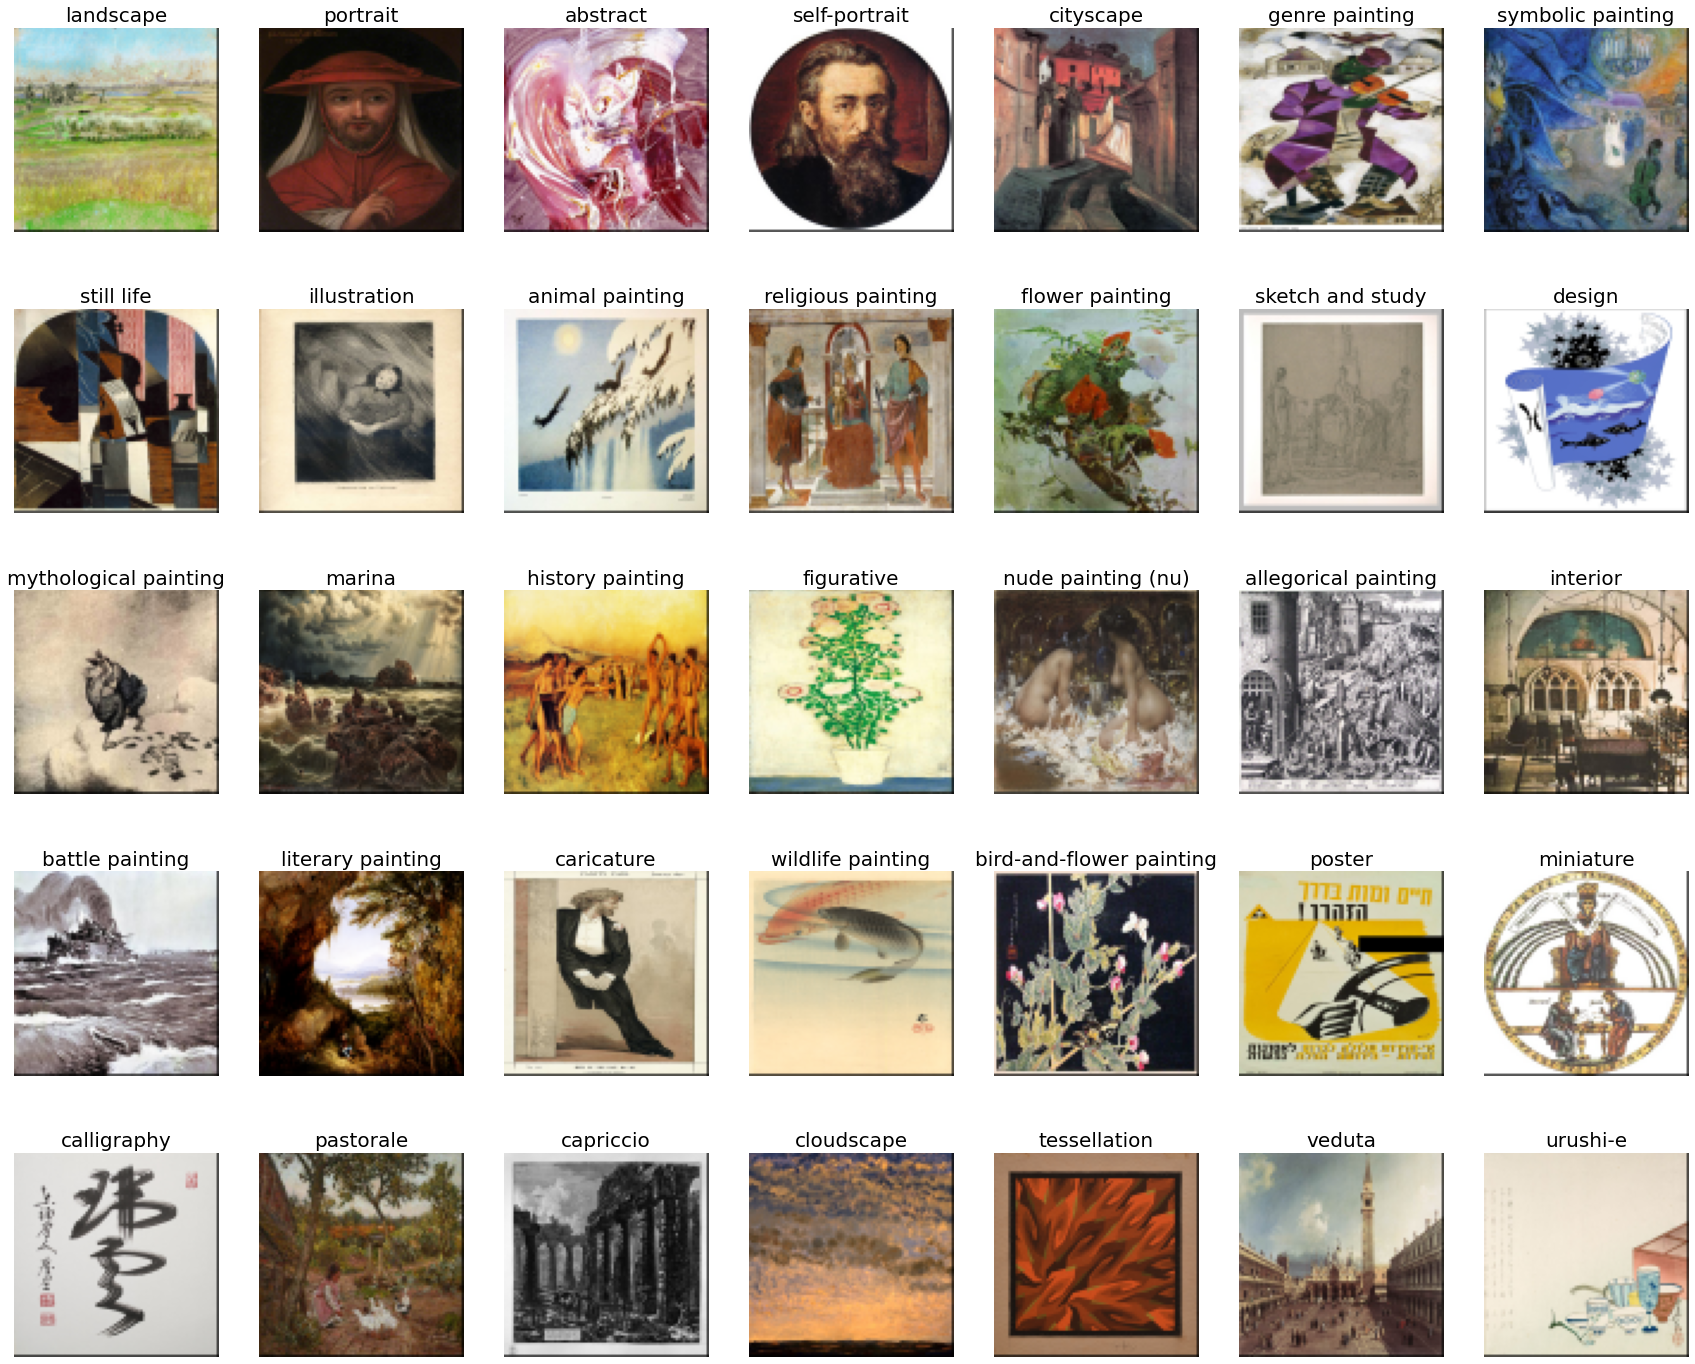

In [90]:
#Now we can graph our images
f, ax = plt.subplots(5, 7, figsize = (30,25))

ax = ax.ravel()
for i in range(len(ind_first_vals)):
  ax[i].imshow(ind_first_vals[i][2])
  ax[i].set_title(ind_first_vals[i][1], fontsize = 20)
  ax[i].axis('off')

# Modeling 
----
Now lets make our convolutional neural net (or as we'll start refering to it - CNN)!

In [92]:
#first we need to make additional imports, for our purposes we'll be using the tensorflow/keras libraries:
import tensorflow as tf
from tensorflow.keras import layers, callbacks

In [ ]:
#Now we'll set up data augmentation layers. This will help generalize our model to new data, as well as ensure that 
#our bootstrapped data isn't just the same image repeated over and over
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
#Next we'll set up callbacks, one to stop our model from traiing once it starts to decrease in accuracy, we'll set our 
#early stopping to occur on the tenth epoch where improvement doesn't occur just to be sure that the model has maxed out
callback1 = callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

#For our second callback we'll model checkpoints that will save our model everytime it improves i accuracy. This will make sure
#that even if our early stopping doesn't capture the maximum accuracy, our checkpooint will
os.mkdir('saved-models/')

callback2 = callbacks.ModelCheckpoint(
    filepath='saved-models/model',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

At this point we're ready to set up the layers of our CNN. We'll utilize convolutional layers, pooling layers, dense layers, as well as dropout layers to get the best result:

In [ ]:
model = tf.keras.Sequential([
  data_augmentation,
  layers.Conv2D(filters= 64,            
                       kernel_size=(3,3),      
                       activation='relu',      
                       input_shape=(86,86,3)),
  layers.Conv2D(32,
                kernel_size=(3,3),
                activation='relu'),
                
  layers.MaxPooling2D(pool_size=(2,2)),
  
  layers.Conv2D(16,
                kernel_size=(3,3),
                activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  
  layers.Flatten(),
  
  layers.Dense(128, activation='relu'),
  
  layers.Dropout(0.2),
  
  layers.Dense(32, activation='relu'),
  
  layers.Dropout(0.2),

 layers.Dense(35, activation='softmax')
])


#Now we'll compile our model
model.compile(loss='sparse_categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])


And now we're ready to fit and train our model!

In [ ]:
results = model.fit(X_train, y_train, validation_data = (X_test, y_test),
                    batch_size=64,
                    epochs=100,
                    callbacks = [callback1, callback2, callback3])

Epoch 1/100
204/204 [==============================] - 453s 2s/step - loss: 3.5234 - accuracy: 0.0465 - val_loss: 3.1013 - val_accuracy: 0.2036
INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved-models/model2/assets
Epoch 2/100
204/204 [==============================] - 450s 2s/step - loss: 3.0465 - accuracy: 0.1992 - val_loss: 2.6666 - val_accuracy: 0.2746
INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved-models/model2/assets
Epoch 3/100
204/204 [==============================] - 447s 2s/step - loss: 2.6970 - accuracy: 0.2735 - val_loss: 2.4542 - val_accuracy: 0.3183
INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved-models/model2/assets
Epoch 4/100
204/204 [==============================] - 446s 2s/step - loss: 2.5618 - accuracy: 0.3044 - val_loss: 2.3525 - val_accuracy: 0.3488
INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved-models/model2/assets
Epoch 5/100
204/204 [==============================] - 445s 2s/step - loss: 2.4410 -

# Results
----

And now we have our model! We were able to max out at 48.36% accuracy. Before we move on we should compare this to some kind of baseline to check how we're doing. In this case, since each genre has the same number of entries, and there are 35 entries, we can caluclate our baseline accuracy as 1/35 or ~ 3%. This means we're predicting well above baseline and we can feel satisfied with this model! Now lets take a look at our model's training results:

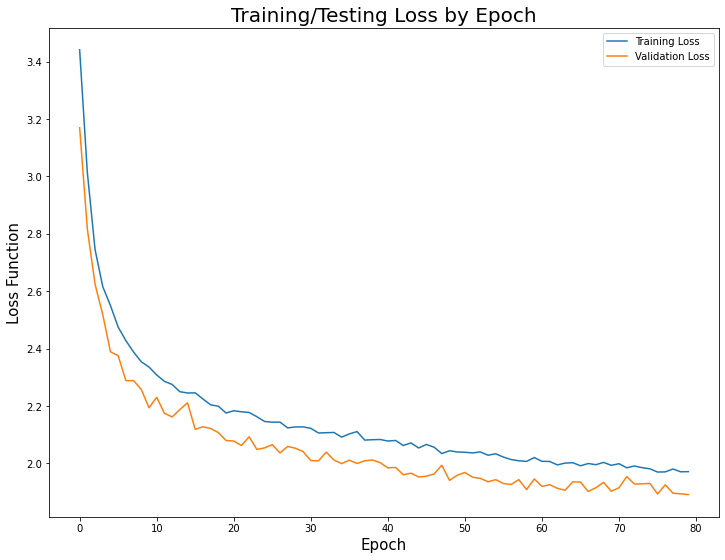

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(results.history['loss'], label = 'Training Loss')
plt.plot(results.history['val_loss'], label = 'Validation Loss')
plt.title('Training/Testing Loss by Epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss Function', fontsize=15)
plt.legend();

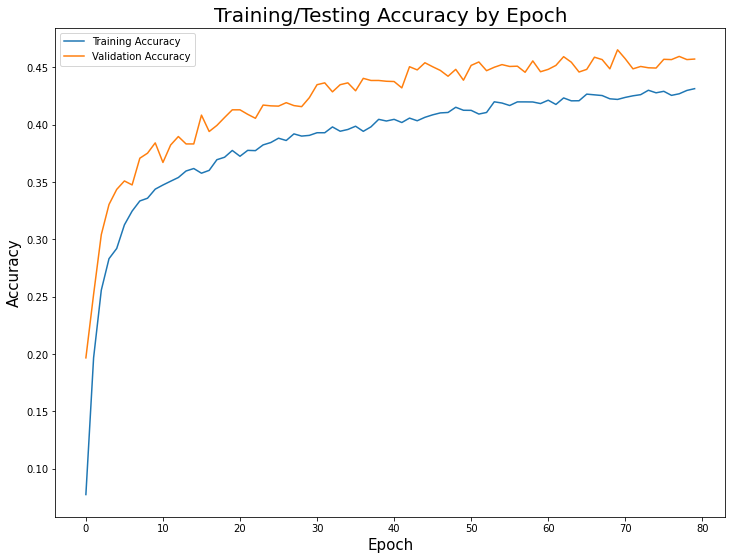

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(results.history['accuracy'], label = 'Training Accuracy')
plt.plot(results.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Training/Testing Accuracy by Epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend();

As can be seen, our model was leveling out in accuracy after hitting 48%, meaning we got the best performance from our model we were going to get. 

Now we can look at how well the model predicts specific images:

In [95]:
#fiat we'll define functions that will predict what an image's genre is and then make a visualization for the predictions
def predict(model = None, pic = None):
  genres = fulldf.cat.unique()
  map = {}
  for x,y in enumerate(genres):
    map[x]=y
  pic = preprocess(pic)
  preds = model.predict(np.expand_dims(pic, axis = 0))
  topk = sorted([[y, map[x]] for x,y in enumerate(preds[0])], reverse = True)[:10]
  result = pd.DataFrame(topk, columns = ['Probability', 'Class']).sort_values('Probability')
  return result

def display_pred(path = None, model = None, genre = None):
  result = predict(model = model, pic = path)
  plt.figure(figsize=(16, 5))
  plt.figure(figsize=(16, 5))
  ax = plt.subplot(1, 2, 1)
  ax.imshow(Image.open(path).resize((256,256)))
  ax.set_title(genre, size=20)
  ax = plt.subplot(1, 2, 2)
  ax.barh(width = result['Probability'], y = result['Class'])
  ax.set_xlabel('Predicted Probability', fontsize = 15)
  ax.set_ylabel('Classes', fontsize = 15)
  plt.show()

In [94]:
#Now we'll read in our saved model:
model = tf.keras.models.load_model('saved-models/model')

<Figure size 1152x360 with 0 Axes>

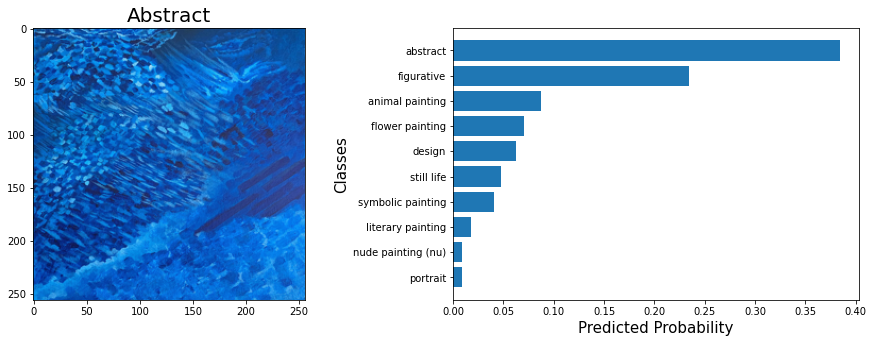

In [ ]:
#and now we can make visualizations:
display_pred(path = 'Abstract-photo.JPG', model = model, genre = 'Abstract')

<Figure size 1152x360 with 0 Axes>

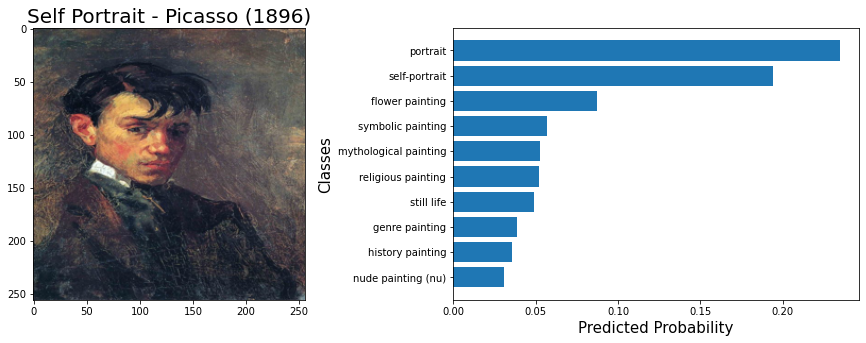

In [ ]:
display_pred(path = 'self-portrait-1896.jpeg', model = model, genre = 'Self Portrait - Picasso (1896)')

<Figure size 1152x360 with 0 Axes>

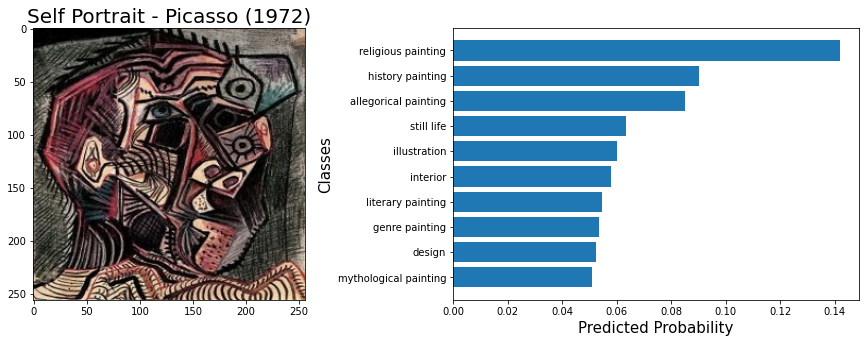

In [ ]:
display_pred(path = 'self-portrait-1972.jpeg.crdownload', model = model, genre = 'Self Portrait - Picasso (1972)')

As can be seen, we were able to predict well for the first two images, however the model is obviously nowhere perfect as abstract art wasn't even in the top ten predictions for the third image.

# Conclusion
----
>While we weren't able to get a model with an accuracy close to 100%, we still managed to beat our baseline by a significant amount with a final accuracy of 48.36%. Ways we could go about improving this is could be through feature extraction, or combining similar genres together, utilizing cloud computing services such as AWS to be able to process more of the data without worrying about computing time, and also pulling from other data sources to supplement the genres with few entries.

# Recommendations
______
This model was made with the intention to help people without a background in art learn more about different genres and generate more interest in them. if an art museum so wished, they could develop this model into a web/phone app and use it to help attract, retain, and educate new memebers. While the model isn't perfect, it could give insight into what genres are most similar to each other, and help people new to art discover their favorites.